In [1]:
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import col, year, to_date, pandas_udf, StringType, size, split
import spacy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
from collections import Counter
from pyspark.ml.feature import NGram, CountVectorizer, Word2Vec
from pyspark.sql.functions import split, explode, desc
import seaborn as sns
import pandas as pd
import os, shutil

In [2]:
# Initialize Spark Session with Increased Driver Memory
spark = SparkSession.builder \
    .appName('ReviewsProcessing') \
    .config('spark.driver.memory', '8g') \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/11/03 00:18:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in reviews data
reviews_df = spark.read.parquet("yelp_reviews.parquet")

In [4]:
reviews_df.show()

+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|           review_id|             user_id|         business_id|stars|useful|funny|cool|                text|               date|
+--------------------+--------------------+--------------------+-----+------+-----+----+--------------------+-------------------+
|KU_O5udG6zpxOg-Vc...|mh_-eMZ6K5RLWhZyI...|XQfwVwDr-v0ZS3_Cb...|  3.0|     0|    0|   0|If you decide to ...|2018-07-07 22:09:11|
|BiTunyQ73aT9WBnpR...|OyoGAe7OKpv6SyGZT...|7ATYjTIgM3jUlt4UM...|  5.0|     1|    0|   1|I've taken a lot ...|2012-01-03 15:28:18|
|saUsX_uimxRlCVr67...|8g_iMtfSiwikVnbP2...|YjUWPpI6HXG530lwP...|  3.0|     0|    0|   0|Family diner. Had...|2014-02-05 20:30:30|
|AqPFMleE6RsU23_au...|_7bHUi9Uuf5__HHc_...|kxX2SOes4o-D3ZQBk...|  5.0|     1|    0|   1|Wow!  Yummy, diff...|2015-01-04 00:01:03|
|Sx8TMOWLNuJBWer-0...|bcjbaE6dDog4jkNY9...|e4Vwtrqf-wpJfwesg...|  4.0|     1|    0|   1|Cu

In [5]:
# Text processing can be slow and resource intensive, let's start with rsaving reviews from a particular year
# First, extract year from reviews date column
year_to_filter = 2022
reviews_df = reviews_df.withColumn("year", year(to_date(col("date"))))
filtered_df = reviews_df.filter(col('year') == year_to_filter)

In [6]:
reviews_pd_df = filtered_df.toPandas()

In [7]:
reviews_pd_df.shape

(31665, 10)

In [8]:
# Merge with businesses to find, how many reviews are for businesses that closed, and categories
dataset_path = 'yelp_dataset'
businesses_df = pd.read_json(f'{dataset_path}/yelp_academic_dataset_business.json', lines=True)
businesses_df.shape

(150346, 14)

In [9]:
businesses_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [10]:
merged_df = pd.merge(reviews_pd_df, businesses_df[["business_id", "categories", "is_open"]], on="business_id", how='left')
merged_df[merged_df.is_open == 0].shape

(94, 12)

In [11]:
merged_df = merged_df.rename(columns={'is_open':'business_open'})

[]

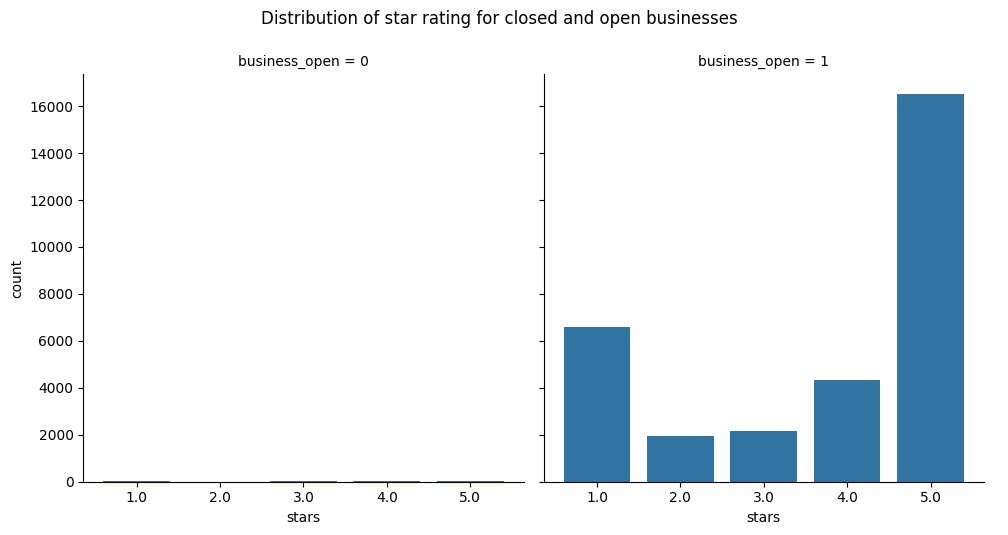

In [12]:
g = sns.catplot(x='stars', data=merged_df, kind='count', col='business_open')
g.fig.suptitle("Distribution of star rating for closed and open businesses", y=1.06)
plt.plot()

In [13]:
# Filter out closed businesses reviews
open_reviews_df = merged_df[merged_df.business_open == 1].copy()

In [14]:
open_reviews_df.shape

(31571, 12)

In [18]:
# Count reviews per business
pd.set_option('display.max_rows', None)
open_reviews_df.business_id.value_counts()[:10]

business_id
ac1AeYqs8Z4_e2X5M3if2A    56
3IUg1tfMbxq6a10WSiK9wQ    43
p76UGLhyXLxUZij1MUsFBA    41
ytynqOUb3hjKeJfRj5Tshw    30
FEXhWNCMkv22qG04E83Qjg    28
oBNrLz4EDhiscSlbOl8uAw    27
SJIQFKTW6uUsOo29w9IHxw    25
VItkA7pL82rCZdxHH8vBGA    24
WVNkMz4sEl35swjVtKHOFw    24
SZU9c8V2GuREDN5KgyHFJw    23
Name: count, dtype: int64

In [16]:
# overwrites be default
path = f'filtered/yelp_reviews_{year_to_filter}.parquet'

# remove folder if it exists (from previous PySpark save)
if os.path.isdir(path):
    shutil.rmtree(path)

# now safely save as a single parquet file
open_reviews_df.to_parquet(path, index=False)

In [17]:
spark.catalog.clearCache()  # clears all cached DataFrames
spark.stop()               # stops the Spark session